### Load waymo_open_dataset package

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

sys.path.append(str(Path().resolve().parent))
from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

W0824 15:10:46.251310 139634967574336 deprecation_wrapper.py:119] From /home/yuma/private/waymo-open-dataset/waymo_open_dataset/utils/range_image_utils.py:59: The name tf.unsorted_segment_max is deprecated. Please use tf.math.unsorted_segment_max instead.

W0824 15:10:46.251833 139634967574336 deprecation_wrapper.py:119] From /home/yuma/private/waymo-open-dataset/waymo_open_dataset/utils/range_image_utils.py:226: The name tf.unsorted_segment_min is deprecated. Please use tf.math.unsorted_segment_min instead.



## Read one frame

Each file in the dataset is a sequence of frames ordered by frame start timestamps. We have extracted two frames from the dataset to demonstrate the dataset format.

In [2]:
FILENAME = './frames'
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break

In [3]:
def parse_range_image_and_camera_projection(frame):
    """Parse range images and camera projections given a frame.

    Args:
        frame: open dataset frame proto
    Returns:
        range_images: A dict of {laser_name,
            [range_image_first_return, range_image_second_return]}.
        camera_projections: A dict of {laser_name,
            [camera_projection_from_first_return,
             camera_projection_from_second_return]}.
        range_image_top_pose: range image pixel pose for top lidar.
    """
    range_images = {}
    camera_projections = {}
    range_image_top_pose = None
    for laser in frame.lasers:
        if len(laser.ri_return1.range_image_compressed) > 0:
            range_image_str_tensor = tf.decode_compressed(
                laser.ri_return1.range_image_compressed, 'ZLIB')
            ri = open_dataset.MatrixFloat()
            ri.ParseFromString(bytearray(range_image_str_tensor.numpy()))
            range_images[laser.name] = [ri]

            if laser.name == open_dataset.LaserName.TOP:
                range_image_top_pose_str_tensor = tf.decode_compressed(
                    laser.ri_return1.range_image_pose_compressed, 'ZLIB')
                range_image_top_pose = open_dataset.MatrixFloat()
                range_image_top_pose.ParseFromString(
                    bytearray(range_image_top_pose_str_tensor.numpy()))

            camera_projection_str_tensor = tf.decode_compressed(
                laser.ri_return1.camera_projection_compressed, 'ZLIB')
            cp = open_dataset.MatrixInt32()
            cp.ParseFromString(bytearray(camera_projection_str_tensor.numpy()))
            camera_projections[laser.name] = [cp]
        if len(laser.ri_return2.range_image_compressed) > 0:
            range_image_str_tensor = tf.decode_compressed(
                laser.ri_return2.range_image_compressed, 'ZLIB')
            ri = open_dataset.MatrixFloat()
            ri.ParseFromString(bytearray(range_image_str_tensor.numpy()))
            range_images[laser.name].append(ri)

            camera_projection_str_tensor = tf.decode_compressed(
                laser.ri_return2.camera_projection_compressed, 'ZLIB')
            cp = open_dataset.MatrixInt32()
            cp.ParseFromString(bytearray(camera_projection_str_tensor.numpy()))
            camera_projections[laser.name].append(cp)
    return range_images, camera_projections, range_image_top_pose


(range_images, camera_projections,
 range_image_top_pose) = parse_range_image_and_camera_projection(frame)

### Examine frame context

Refer to [dataset.proto](https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/dataset.proto) for the data format. The context contains shared information among all frames in the scene.

In [4]:
print(frame.context)

name: "11004685739714500220_2300_000_2320_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2055.556149361639
  intrinsic: 2055.556149361639
  intrinsic: 939.6574698861468
  intrinsic: 641.0721821943271
  intrinsic: 0.03231600849798887
  intrinsic: -0.3214124825527059
  intrinsic: 0.0007932583953709973
  intrinsic: -0.0006257493541333847
  intrinsic: 0.0
  extrinsic {
    transform: 0.9998926849887427
    transform: -0.005993208400016058
    transform: 0.0133678704017097
    transform: 1.5389142447125008
    transform: 0.006042236521329663
    transform: 0.9999751560547995
    transform: -0.003630241176497072
    transform: -0.02363394083934774
    transform: -0.013345781499156929
    transform: 0.003710623431877962
    transform: 0.999904056092345
    transform: 2.115270572975561
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: LEFT_TO_RIGHT
}
camera_calibrations {
  name: FRONT_LEFT
  intrins

## Visualize Camera Images

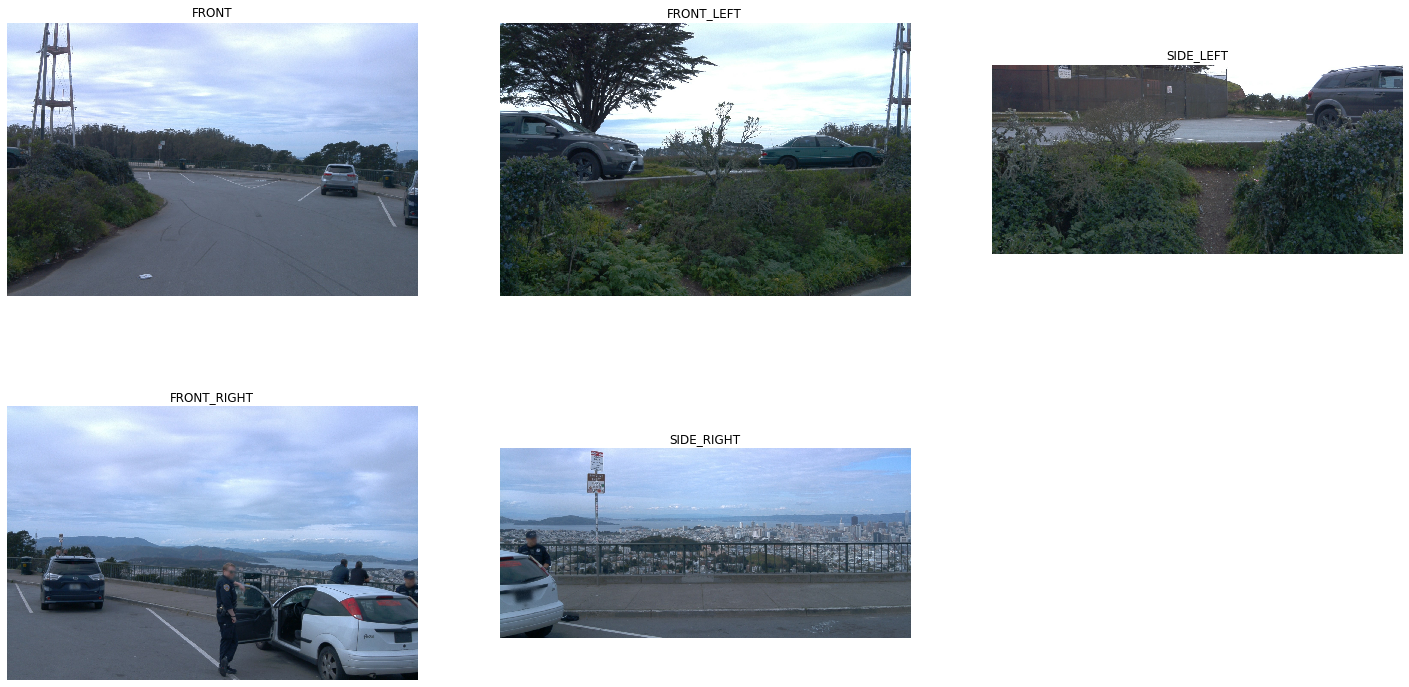

In [5]:
plt.figure(figsize=(25, 20))

def image_show(data, name, layout, cmap=None):
    """Show an image."""
    plt.subplot(*layout)
    plt.imshow(tf.image.decode_jpeg(data), cmap=cmap)
    plt.title(name)
    plt.grid(False)
    plt.axis('off')

for index, image in enumerate(frame.images):
    image_show(image.image, open_dataset.CameraName.Name.Name(image.name),
               [3, 3, index + 1])

## Visualize Range Images

W0824 15:10:48.027043 139634967574336 deprecation.py:323] From <ipython-input-6-6bdf95a6a2f6>:37: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


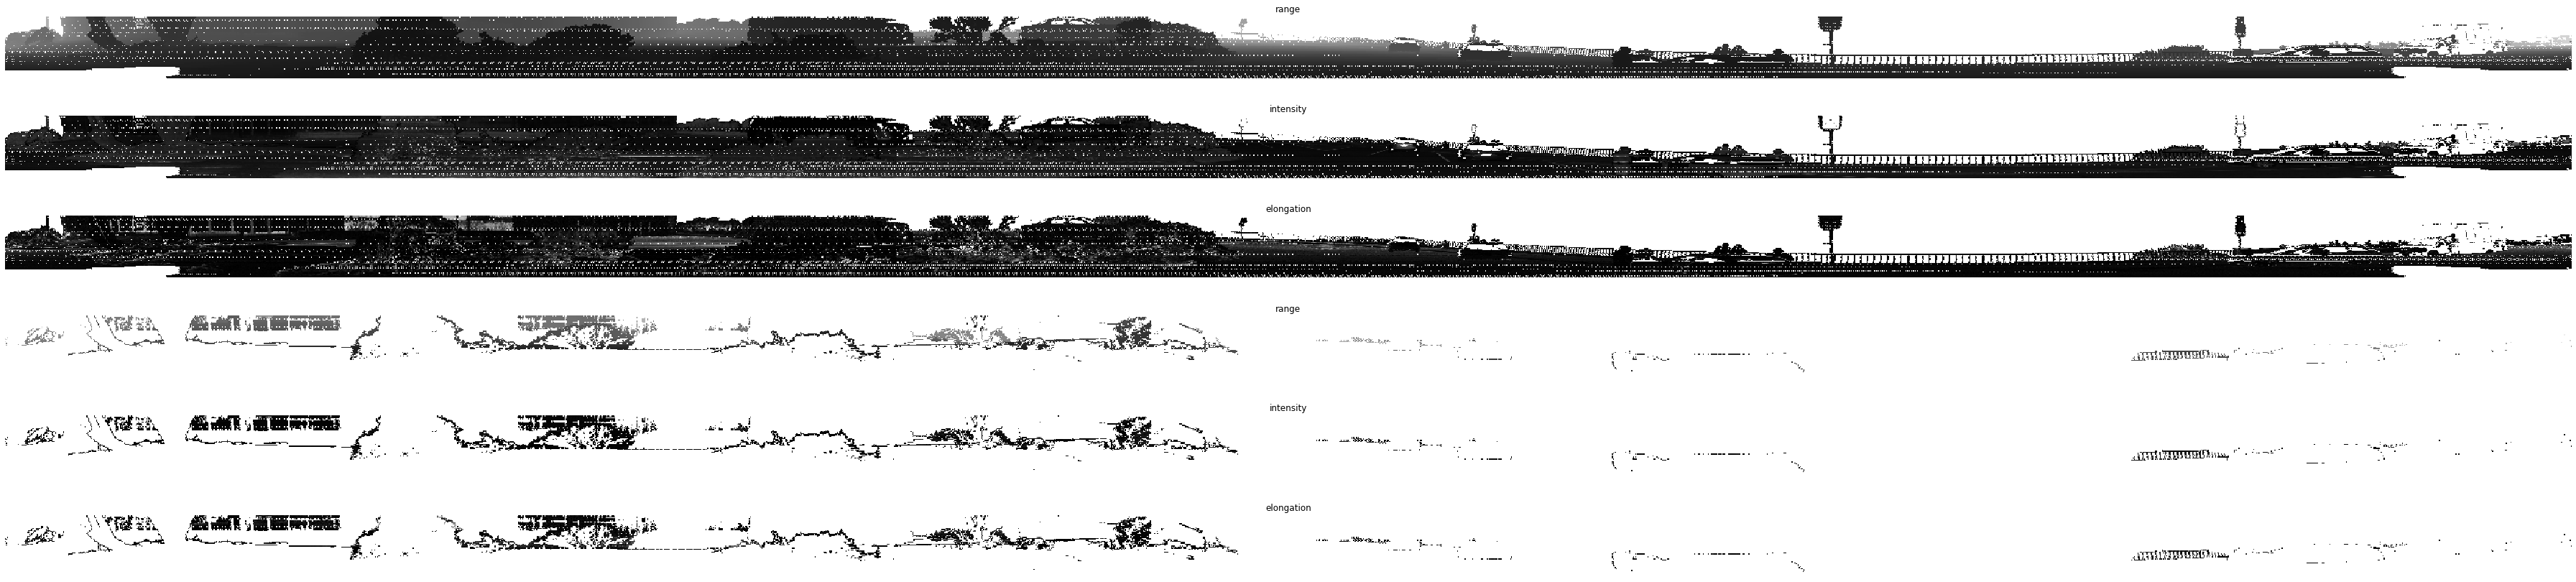

In [6]:
plt.figure(figsize=(64, 20))

def plot_range_image_helper(data, name, layout, vmin=0, vmax=1, cmap='gray'):
    """Plots range image.

    Args:
        data: range image data
        name: the image title
        layout: plt layout
        vmin: minimum value of the passed data
        vmax: maximum value of the passed data
        cmap: color map
    """
    plt.subplot(*layout)
    plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(name)
    plt.grid(False)
    plt.axis('off')


def get_range_image(laser_name, return_index):
    """Returns range image given a laser name and its return index."""
    return range_images[laser_name][return_index]


def show_range_image(range_image, layout_index_start=1):
    """Shows range image.

    Args:
        range_image: the range image data from a given lidar of type MatrixFloat.
        layout_index_start: layout offset
    """
    range_image_tensor = tf.convert_to_tensor(range_image.data)
    range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
    lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
    range_image_tensor = tf.where(lidar_image_mask, range_image_tensor,
                                  tf.ones_like(range_image_tensor) * 1e10)
    range_image_range = range_image_tensor[..., 0]
    range_image_intensity = range_image_tensor[..., 1]
    range_image_elongation = range_image_tensor[..., 2]
    plot_range_image_helper(range_image_range.numpy(),
                            'range', [8, 1, layout_index_start],
                            vmax=75,
                            cmap='gray')
    plot_range_image_helper(range_image_intensity.numpy(),
                            'intensity', [8, 1, layout_index_start + 1],
                            vmax=1.5,
                            cmap='gray')
    plot_range_image_helper(range_image_elongation.numpy(),
                            'elongation', [8, 1, layout_index_start + 2],
                            vmax=1.5,
                            cmap='gray')


frame.lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 1), 4)

## Point Cloud Conversion and Visualization

In [7]:
def convert_range_image_to_point_cloud(frame,
                                       range_images,
                                       camera_projections,
                                       range_image_top_pose,
                                       ri_index=0):
    """Convert range images to point cloud.

    Args:
        frame: open dataset frame
        range_images: A dict of {laser_name,
            [range_image_first_return, range_image_second_return]}.
        camera_projections: A dict of {laser_name,
            [camera_projection_from_first_return,
             camera_projection_from_second_return]}.
        range_image_top_pose: range image pixel pose for top lidar.
        ri_index: 0 for the first return, 1 for the second return.
    Returns:
        points: {[N, 3]} list of 3d lidar points of length 5 (number of lidars).
        cp_points: {[N, 6]} list of camera projections of length 5 (number of lidars).
    """
    calibrations = sorted(frame.context.laser_calibrations,
                          key=lambda c: c.name)
    lasers = sorted(frame.lasers, key=lambda laser: laser.name)
    points = []
    cp_points = []

    frame_pose = tf.convert_to_tensor(
        np.reshape(np.array(frame.pose.transform), [4, 4]))
    # [H, W, 6]
    range_image_top_pose_tensor = tf.reshape(
        tf.convert_to_tensor(range_image_top_pose.data),
        range_image_top_pose.shape.dims)
    # [H, W, 3, 3]
    range_image_top_pose_tensor_rotation = transform_utils.get_rotation_matrix(
        range_image_top_pose_tensor[..., 0],
        range_image_top_pose_tensor[..., 1],
        range_image_top_pose_tensor[..., 2])
    range_image_top_pose_tensor_translation = range_image_top_pose_tensor[...,
                                                                          3:]
    range_image_top_pose_tensor = transform_utils.get_transform(
        range_image_top_pose_tensor_rotation,
        range_image_top_pose_tensor_translation)
    for c in calibrations:
        range_image = range_images[c.name][ri_index]
        if len(c.beam_inclinations) == 0:
            beam_inclinations = range_image_utils.compute_inclination(
                tf.constant([c.beam_inclination_min, c.beam_inclination_max]),
                height=range_image.shape.dims[0])
        else:
            beam_inclinations = tf.constant(c.beam_inclinations)

        beam_inclinations = tf.reverse(beam_inclinations, axis=[-1])
        extrinsic = np.reshape(np.array(c.extrinsic.transform), [4, 4])

        range_image_tensor = tf.reshape(tf.convert_to_tensor(range_image.data),
                                        range_image.shape.dims)
        pixel_pose_local = None
        frame_pose_local = None
        if c.name == open_dataset.LaserName.TOP:
            pixel_pose_local = range_image_top_pose_tensor
            pixel_pose_local = tf.expand_dims(pixel_pose_local, axis=0)
            frame_pose_local = tf.expand_dims(frame_pose, axis=0)
        range_image_mask = range_image_tensor[..., 0] > 0
        range_image_cartesian = range_image_utils.extract_point_cloud_from_range_image(
            tf.expand_dims(range_image_tensor[..., 0], axis=0),
            tf.expand_dims(extrinsic, axis=0),
            tf.expand_dims(tf.convert_to_tensor(beam_inclinations), axis=0),
            pixel_pose=pixel_pose_local,
            frame_pose=frame_pose_local)

        range_image_cartesian = tf.squeeze(range_image_cartesian, axis=0)
        points_tensor = tf.gather_nd(range_image_cartesian,
                                     tf.where(range_image_mask))

        cp = camera_projections[c.name][0]
        cp_tensor = tf.reshape(tf.convert_to_tensor(cp.data), cp.shape.dims)
        cp_points_tensor = tf.gather_nd(cp_tensor, tf.where(range_image_mask))
        points.append(points_tensor.numpy())
        cp_points.append(cp_points_tensor.numpy())

    return points, cp_points


points, cp_points = convert_range_image_to_point_cloud(frame, range_images,
                                                       camera_projections,
                                                       range_image_top_pose)
points_ri2, cp_points_ri2 = convert_range_image_to_point_cloud(
    frame, range_images, camera_projections, range_image_top_pose, ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

W0824 15:10:49.404173 139634967574336 deprecation_wrapper.py:119] From /home/yuma/private/waymo-open-dataset/waymo_open_dataset/utils/range_image_utils.py:207: The name tf.matrix_inverse is deprecated. Please use tf.linalg.inv instead.



### Examine number of points in each lidar sensor.

First return.

In [8]:
print(points_all.shape)
print(cp_points_all.shape)
print(points_all[0:2])

for i in range(5):
    print(points[i].shape)
    print(cp_points[i].shape)

(126805, 3)
(126805, 6)
[[-51.139       5.1010137   4.3288565]
 [-51.3299      5.2447767   4.336956 ]]
(108996, 3)
(108996, 6)
(4041, 3)
(4041, 6)
(5184, 3)
(5184, 6)
(4108, 3)
(4108, 6)
(4476, 3)
(4476, 6)


Second return.

In [9]:
print(points_all_ri2.shape)
print(cp_points_all_ri2.shape)
print(points_all_ri2[0:2])

for i in range(5):
    print(points_ri2[i].shape)
    print(cp_points_ri2[i].shape)

(10104, 3)
(10104, 6)
[[-31.753202    6.5761647   3.5490725]
 [-15.778538    4.07078     2.8928587]]
(9868, 3)
(9868, 6)
(53, 3)
(53, 6)
(125, 3)
(125, 6)
(9, 3)
(9, 6)
(49, 3)
(49, 6)


### Show point cloud
3D point clouds are rendered using an internal tool, which is unfortunately not publicly available yet. Here is an example of what they look like.

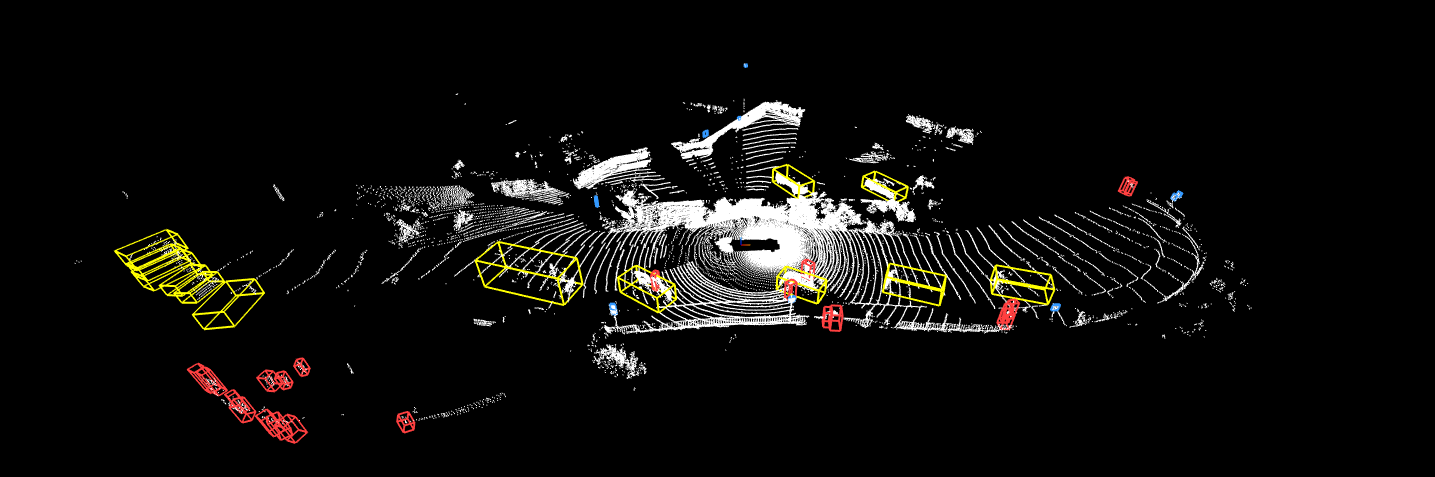

In [10]:
from IPython.display import Image, display
display(Image('./3d_point_cloud.png'))

## Visualize Camera Projection

In [11]:
images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

# The distance between lidar points and vehicle frame origin.
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[..., 0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat(
    [cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [12]:
def rgba(r):
    """Generates a color based on range.

    Args:
        r: the range value of a given point.
    Returns:
        The color for a given range
    """
    c = plt.get_cmap('jet')((r % 20.0) / 20.0)
    c = list(c)
    c[-1] = 0.5  # alpha
    return c


def plot_image(camera_image):
    """Plot a cmaera image."""
    plt.figure(figsize=(20, 12))
    plt.imshow(tf.image.decode_jpeg(camera_image.image))
    plt.grid("off")


def plot_points_on_image(projected_points,
                         camera_image,
                         rgba_func,
                         point_size=5.0):
    """Plots points on a camera image.

    Args:
        projected_points: [N, 3] numpy array. The inner dims are [camera_x, camera_y, range].
        camera_image: jpeg encoded camera image.
        rgba_func: a function that generates a color from a range value.
        point_size: the point size.

    """
    plot_image(camera_image)

    xs = []
    ys = []
    colors = []

    for point in projected_points:
        xs.append(point[0])  # width, col
        ys.append(point[1])  # height, row
        colors.append(rgba_func(point[2]))

    plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

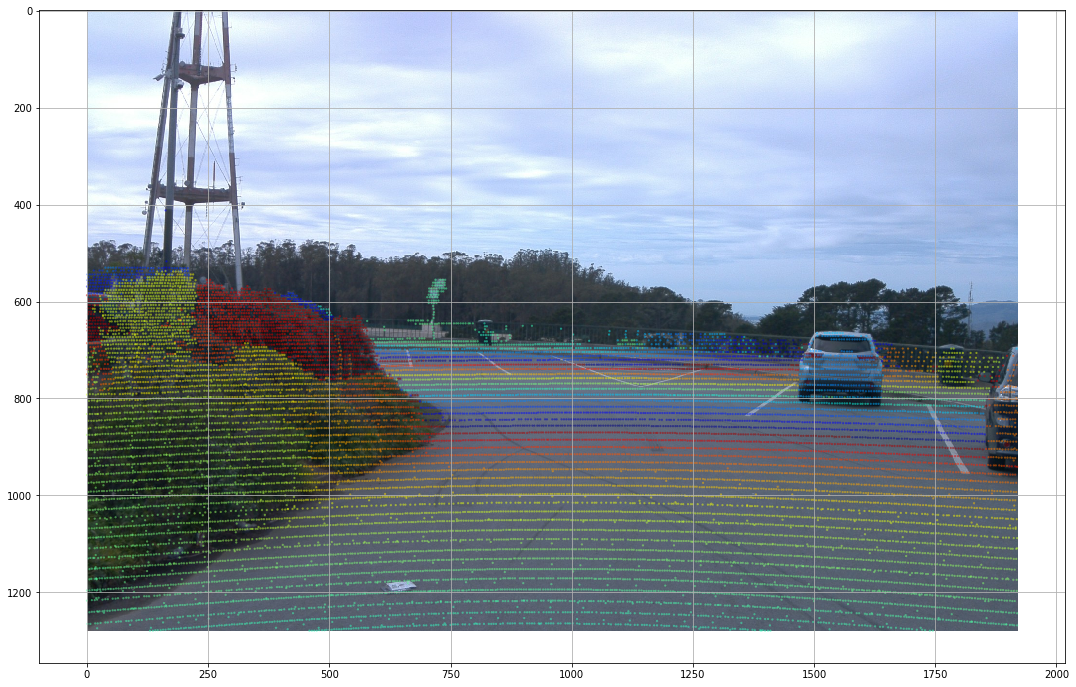

In [13]:
plot_points_on_image(projected_points_all_from_raw_data,
                     images[0], rgba, point_size=5.0)